In [1]:
# Python Free Fermion Large Scale Simulation Platform (FreeFermiNet) Tutorials
# Author: Bill Zhai pzhai@g.harvard.edu
# PI: Susanne F. Yelin
# Nov 30, 2022

In [2]:
import os
from Utils_torch_version import Network, get_nn_pairs, binary_basis, unpacknbits, initialize_sparse, \
    mnist_single_pdf, mix_rbf_kernel, kernel_expect, mnist_single_binary

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import scipy.linalg
import time
import torch # PyTorch is required for this demo
import qiskit # Qiskit is required for this demo
import math
import seaborn as sns


import torch
import matplotlib.pyplot as plt
import qiskit
import numpy as np

# Example 6: Large Scale Pattern Recognition

In this simple example, we demonstrate the differentiable learning of a series quantum Hamiltonian such at the output state has high probability ($\approx 1$) of outputting a discrete MNIST image pattern as defined by the upward and downward spins of the bit string measurement. This exmaple is a simplified quantum Born Machine where we demonostrate the large-scale simulability of learning one image pattern.

Refer to Example 4 for more on quantum Born Machine (replicated here):

The quantum circuit Born Machine (QCBM) is a quantum generative model. 

QCBM utilizes a multi-layer parametrized quantum circuit (MPQC) to evolve the initial/input quantum state $|\psi_0\rangle$ to some target state via unitary gates: $\left|\psi_{\theta}\right\rangle=U_{\theta}|\psi_0\rangle$, where $\theta$ are the parameters of the MPQ. One measures the outputs state in the computational basis to produce a classical sample (bit string) $x \sim p_{\boldsymbol{\theta}}(x)=\left|\left\langle x | \psi_{\theta}\right\rangle\right|^{2}$. Excitingly, the output probability densities of a general quantum circuit cannot be efficiently simulated by classical means, the QCBM is among the several proposals to show quantum supremacy. QCBM by minimizing the maximum mean discrepancy (MMD) loss using a Gaussian Kernel:

$\begin{equation}
    \begin{aligned}
\mathcal{L}&=\underset{x \sim p_{\theta}, y \sim p_{\theta}}{\mathbb{E}}[K(x, y)]-2 \underset{x \sim p_{\theta}, y \sim p^*}{\mathbb{E}}[K(x, y)]+\underset{x \sim p^*, y \sim p^*}{\mathbb{E}}[K(x, y)],
\end{aligned}
\end{equation}.$

In this tutorial, we use a simple multi-layer parametrized quantum circuit with related FreeFermiNet classes and functions.

We define one circuit gate Hamiltonian as $H_g$, and each gate corresponds to a continuous evolution $e^{-i\mathcal{H}_{g}t}$. A parametrized is a series of such evolutions:

$U_{total} = U_L U_{L-1}...U_{2} U_1, $

where $U_l$ is the $l$-th "layer" defined as:

$U_l = e^{-i\mathcal{H}_{l}t},$

where at each layer, $\mathcal{H}_{l}$ concerns interactionos of two Fermionic modes $i<j$, not necessarily nearest-neighbor. In this example, we use a simple construction (refer to Tutorial 1 for more details):

$\begin{equation}
    \begin{aligned}
        \mathcal{H}_{l} &=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+(c+di) a_i^{\dagger} a_j+(c-di) a_j^{\dagger} a_i \\ &= -\frac{1}{2} \left(b_{ii} Z_i + b_{jj} Z_j\right)+\frac{c}{2} \left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j + X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j \right)\\
        &+\frac{d}{2}\left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j - X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j \right),
    \end{aligned}
\end{equation}$

In [3]:
q_data, data_digit = mnist_single_pdf(9, 17, 14)
q_data_img = (q_data>0.001).int()
q_data = q_data_img.flatten().unsqueeze(0)

In [4]:
q_data[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.int32)

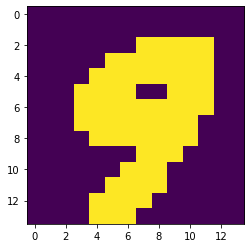

In [9]:
plt.imshow(q_data_img)

In [5]:
q_data.shape

torch.Size([1, 196])

In [6]:
n_fermions = 68
factor = 1
N = 14**2
# basis_m_n = binary_basis(geometry=(n_fermions,)) # The basis in the probability space

conn_list = [ [np.min(p), np.max(p)] for p in get_nn_pairs(geometry=(N,))]*1

print('conn_list', conn_list)
L = len(conn_list) # Number of layers

# 101010...10
x_input = torch.tensor([[1,0]*(n_fermions)+[0]*(N-2*n_fermions)]) if N%2==0 else torch.tensor([[1,0]*int(N/2)+[1]])

# Initialize the circuit
circuit = Network(conn_list, N)
print('circuit.parameters()', circuit.parameters())

# Initialize the circuit
circuit = Network(conn_list, N)

beta1 = 0.5
lr_G = 1e-1
optimizerG = torch.optim.Adam(circuit.parameters(), lr=lr_G, betas=(beta1, 0.999)) #The parameters are the th
# def kl(p_data, probs_batch):
#     return torch.sum(p_data * torch.log(p_data/(probs_batch+1e-12)))
# def tv_sqr(p_data, probs_batch):
#     return torch.sum(torch.square(probs_batch-p_data))


# # MMD loss by tracking the full probability space [0.5, 0.1, 0.2, 0.25,4,10]
# # K = torch.tensor(mix_rbf_kernel(basis_m_n, basis_m_n, sigma_list=[0.002, 0.5, 0.1, 0.2, 0.25,4,10]), dtype=torch.float)
# def exact_mmd(pdf_data, pdf_model): #input are tensors
#     # print('debug pdf_data', pdf_data)
#     # print('debug pdf_model', pdf_model)
#     # parmas_L_by_4 = parmas_L_times_4.reshape((L, 4))
#     # bij_vec = parmas_L_by_4[:,2]+parmas_L_by_4[:,3]*1j # the bij has a real part and a complex part
#     # params_L_3 = np.concatenate((parmas_L_by_4[:,0:2], bij_vec[:,None]), axis=1)
#     p_diff = pdf_data-pdf_model # Although this puts a constant term to the loss value, it is easier to code this way
#     return kernel_expect(K, p_diff, p_diff)



conn_list [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [50, 51], [52, 53], [54, 55], [56, 57], [58, 59], [60, 61], [62, 63], [64, 65], [66, 67], [68, 69], [70, 71], [72, 73], [74, 75], [76, 77], [78, 79], [80, 81], [82, 83], [84, 85], [86, 87], [88, 89], [90, 91], [92, 93], [94, 95], [96, 97], [98, 99], [100, 101], [102, 103], [104, 105], [106, 107], [108, 109], [110, 111], [112, 113], [114, 115], [116, 117], [118, 119], [120, 121], [122, 123], [124, 125], [126, 127], [128, 129], [130, 131], [132, 133], [134, 135], [136, 137], [138, 139], [140, 141], [142, 143], [144, 145], [146, 147], [148, 149], [150, 151], [152, 153], [154, 155], [156, 157], [158, 159], [160, 161], [162, 163], [164, 165], [166, 167], [168, 169], [170, 171], [172, 173], [174, 175], [176, 177], [178, 179], [180, 181], [182, 1

In [7]:
prob_list = []
for itr in range(20):
    circuit.zero_grad() # clear the parameter gradients
    y_batch = q_data # data pattern
    x_batch = q_data
    sub_mask_batch = (torch.tensor([ [1]*(N) ])).repeat(y_batch.shape[0], 1)
    ts = time.time()
#     probs_batch = -torch.abs(circuit.forward(y_batch, x_batch))
    probs_batch = -circuit.forward_partial_observation(y_batch, x_batch, sub_mask_batch).real
    print('iter, obj', (itr, probs_batch))
    
    probs_batch.backward()
    optimizerG.step()
    tf = time.time()
    print('total time', tf-ts)
    prob_list.append(probs_batch)
#     print('gradients', )
#     grads_l_list = []
#     for l in range(L):
#         # each layer has four parameters
#         grads_l = np.array([[circuit.V_l_module_list[l].bii.grad.detach().numpy()[0], circuit.V_l_module_list[l].bjj.grad.detach().numpy()[0],\
#          circuit.V_l_module_list[l].bij_real.grad.detach().numpy()[0], \
#         circuit.V_l_module_list[l].bij_img.grad.detach().numpy()[0]]])

        
#         grads_l_list.append(grads_l)
#     print(grads_l_list)

iter, obj (0, tensor([-2.7732e-07], grad_fn=<NegBackward0>))
total time 5.470883131027222
iter, obj (1, tensor([-3.2231e-05], grad_fn=<NegBackward0>))
total time 4.4588401317596436
iter, obj (2, tensor([-0.0010], grad_fn=<NegBackward0>))
total time 4.225444793701172
iter, obj (3, tensor([-0.0133], grad_fn=<NegBackward0>))
total time 4.341095924377441
iter, obj (4, tensor([-0.0850], grad_fn=<NegBackward0>))
total time 5.288283109664917
iter, obj (5, tensor([-0.2899], grad_fn=<NegBackward0>))
total time 5.294484853744507
iter, obj (6, tensor([-0.6268], grad_fn=<NegBackward0>))
total time 4.357120037078857
iter, obj (7, tensor([-0.8508], grad_fn=<NegBackward0>))
total time 4.546244144439697
iter, obj (8, tensor([-0.9465], grad_fn=<NegBackward0>))
total time 4.561734199523926
iter, obj (9, tensor([-0.9451], grad_fn=<NegBackward0>))
total time 5.098164081573486
iter, obj (10, tensor([-0.9653], grad_fn=<NegBackward0>))
total time 4.455838918685913
iter, obj (11, tensor([-0.9833], grad_fn=<Ne

Text(0.5, 1.0, 'prob of outputing target pattern')

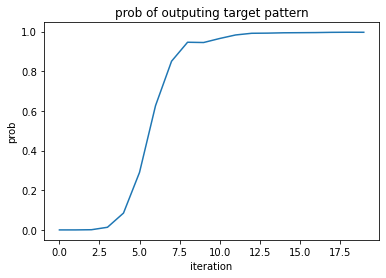

In [8]:
prob_list = torch.tensor(prob_list)
plt.plot(-prob_list)
plt.xlabel('iteration')
plt.ylabel('prob')
plt.title('prob of outputing target pattern')